In [1]:
%matplotlib inline

import sys, os

sys.path.append(os.path.abspath(os.path.join('..', 'datasets/')))
from tools import *

#Attribute Information:

Name -- Data Type -- Measurement -- Description 

Cement (component 1) -- quantitative -- kg in a m3 mixture -- Input Variable 

Blast Furnace Slag (component 2) -- quantitative -- kg in a m3 mixture -- Input Variable 

Fly Ash (component 3) -- quantitative -- kg in a m3 mixture -- Input Variable 

Water (component 4) -- quantitative -- kg in a m3 mixture -- Input Variable 

Superplasticizer (component 5) -- quantitative -- kg in a m3 mixture -- Input Variable 

Coarse Aggregate (component 6) -- quantitative -- kg in a m3 mixture -- Input Variable 

Fine Aggregate (component 7)	-- quantitative -- kg in a m3 mixture -- Input Variable 

Age -- quantitative -- Day (1~365) -- Input Variable 

Concrete compressive strength -- quantitative -- MPa -- Output Variable 

In [2]:
names = ["cement", "blast_slag", "fly_ash", "water", "superplasticizer", "coarse_aggregate", "fine_aggregate",
        "age", "compressive_strength"]

df = pd.read_excel("../datasets/raw/concrete/Concrete_Data.xls", names=names)

In [3]:
df.head()

,cement,blast_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,compressive_strength
0,540.0,0.0,0,162,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0,162,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0,228,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0,228,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0,192,0.0,978.4,825.5,360,44.296075


In [4]:
df.describe()

,cement,blast_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,compressive_strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


In [5]:
_, df = scale(df)

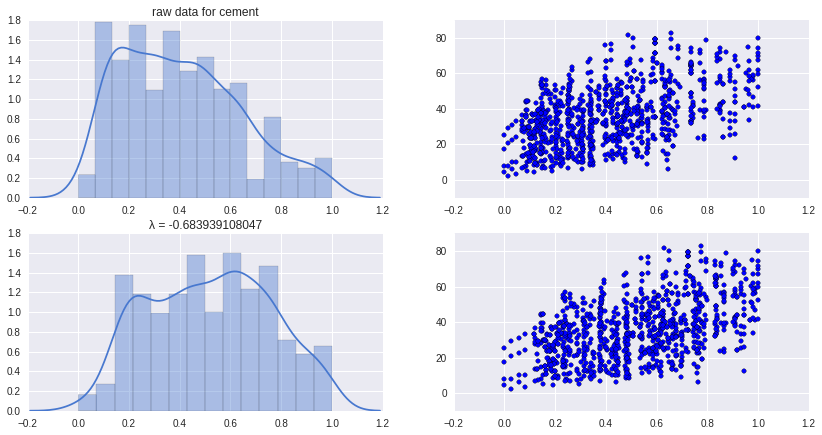

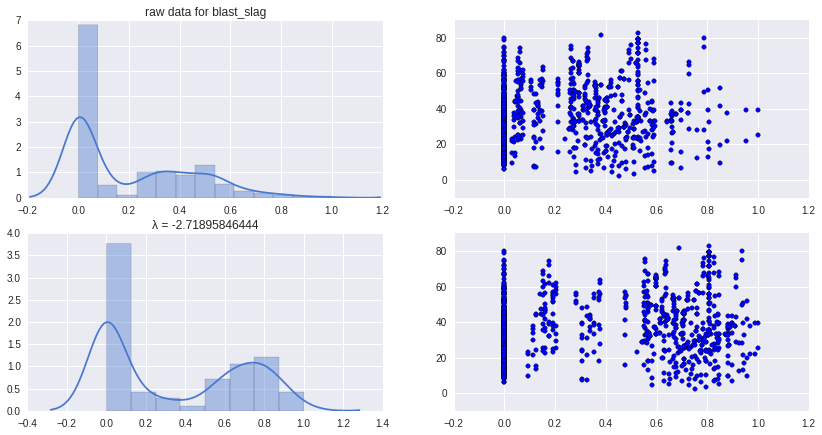

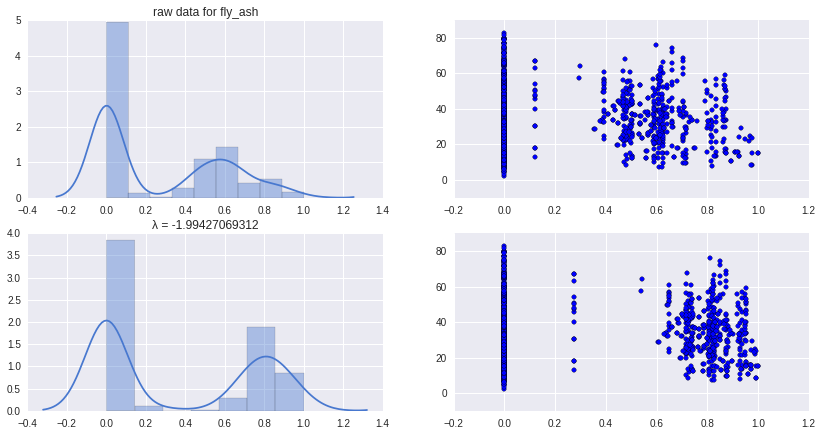

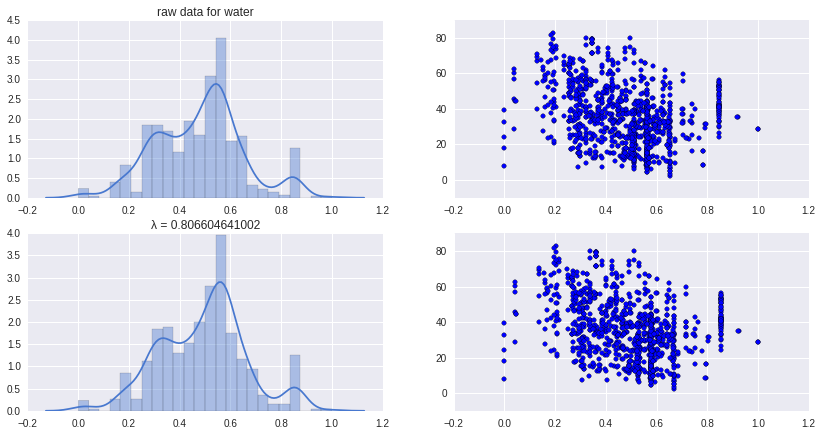

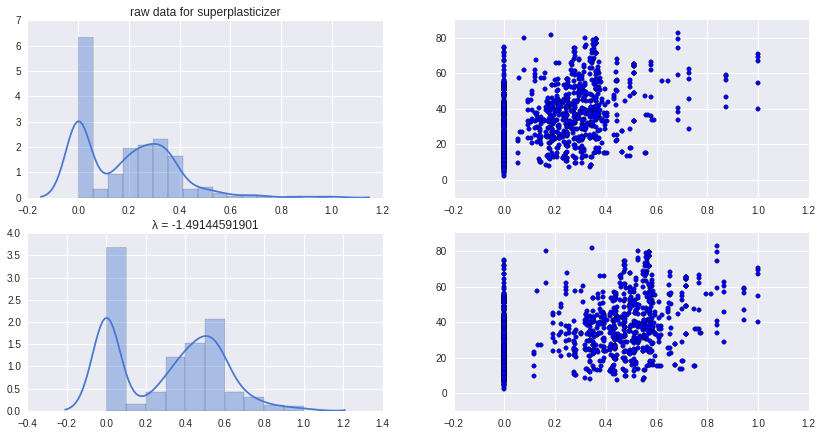

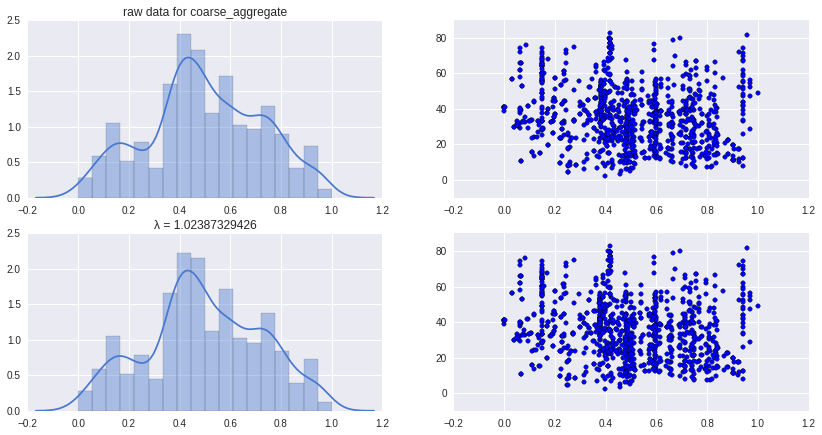

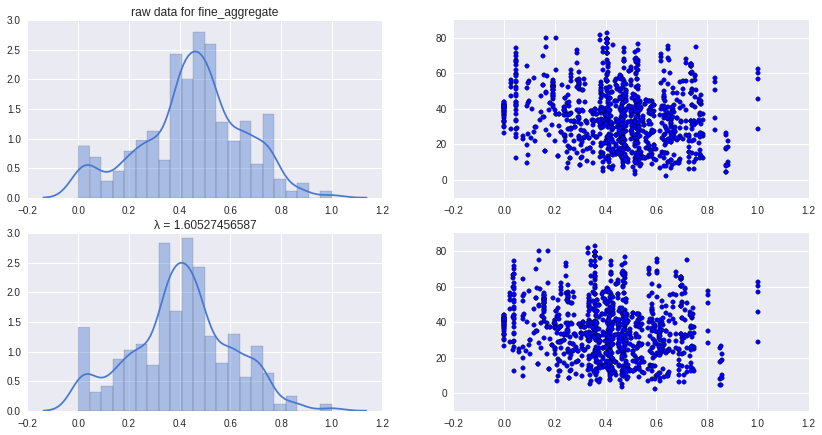

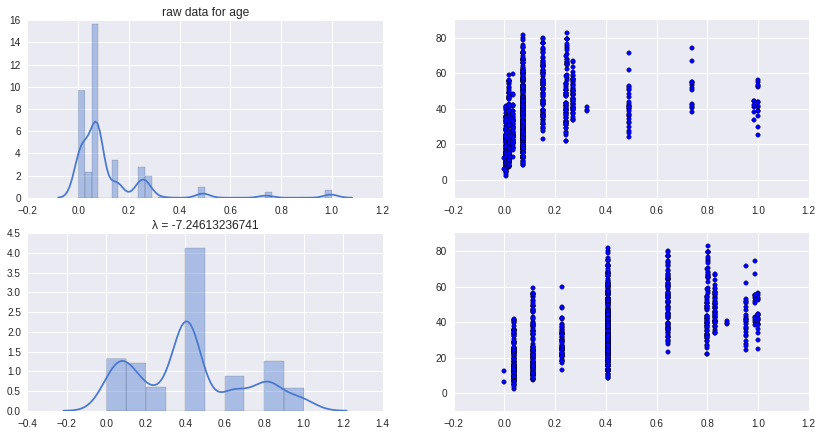

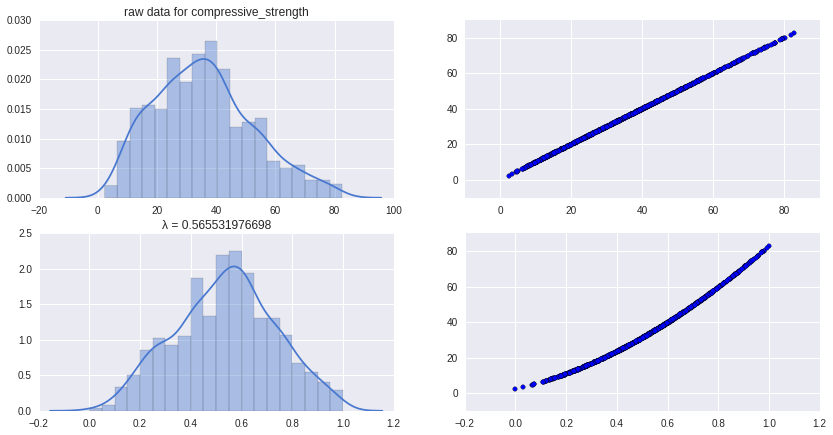

In [6]:
lambdas = plot_cox_df(df)

In [7]:
lambdas["coarse_aggregate"] = 1
lambdas

{'age': -7.2461323674095635,
 'blast_slag': -2.7189584644377498,
 'cement': -0.6839391080474353,
 'coarse_aggregate': 1,
 'compressive_strength': 1,
 'fine_aggregate': 1.6052745658692371,
 'fly_ash': -1.9942706931166276,
 'superplasticizer': -1.4914459190124418,
 'water': 0.806604641002032}

In [8]:
df = transform_cox(df,lambdas)

In [9]:
X = np.array(df.ix[:,0:-1])
y = df.ix[:,-1]

In [10]:
def plotGridSearch(gridSearch, T=0.0):
    scores = gridSearch.grid_scores_
    diag_scores = [s for s in scores if s[0]['typeReg'] == 2]
    ident_scores = [s for s in scores if s[0]['typeReg'] == 0]
    diag_params,diag_mean, diag_std = zip(*diag_scores)
    ident_params, ident_mean, ident_std = zip(*ident_scores)
    diag_mean = np.sqrt([-x for x in diag_mean])
    ident_mean = np.sqrt([-x for x in ident_mean])
    lambdas = [l['lambdaReg'] for l in diag_params]
    diff_mean = diag_mean - ident_mean

    fig = plt.figure(2, figsize=(15,5))

    ax1 = fig.add_subplot(121)
    ax1.set_ylabel("RMSE")
    ax1.set_xlabel("Lambda")
    ax1.plot(lambdas, diag_mean)
    ax1.plot(lambdas, ident_mean)
    ax1.legend(["Diagonal", "Identity"])
    ax1.set_xscale('log')
    ax1.invert_xaxis()
    ax1.set_title("RMSE for T = " + str(T))

    ax2 = fig.add_subplot(122)
    ax2.plot(lambdas, diff_mean)
    ax2.set_ylabel("RMSE difference")
    ax2.set_xlabel("Lambda")
    ax2.legend(["diag - ident"])
    1ax2.set_xscale('log')
    ax2.invert_xaxis()
    ax2.set_title("No. of gridpoints " + str(gridSearch.best_estimator_.getGridSize()))

    fig.show()

def autoGridSearchWithT(X, Y, parameters, lambdaGrid, T=0.0):
    learner = SGRegressionLearner(T=T)
    shuffle = cv.ShuffleSplit(X.shape[0], n_iter=5, random_state=42)
    parameters = [{"lambdaReg": lambdaGrid, "typeReg": [2]}, # diag
                  {"lambdaReg": lambdaGrid, "typeReg": [0]}] # ident
    gridSearch = sklearn.grid_search.GridSearchCV(learner, parameters, cv=shuffle, verbose=1, n_jobs=4)
    gridSearch.fit(X,Y)
    plotGridSearch(gridSearch, T)
    return gridSearch


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 450 jobs       | elapsed: 15.4min
[Parallel(n_jobs=4)]: Done 800 jobs       | elapsed: 24.0min
[Parallel(n_jobs=4)]: Done 994 out of 1000 | elapsed: 32.9min remaining:   11.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 33.2min finished
/home/lukaskrenz/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


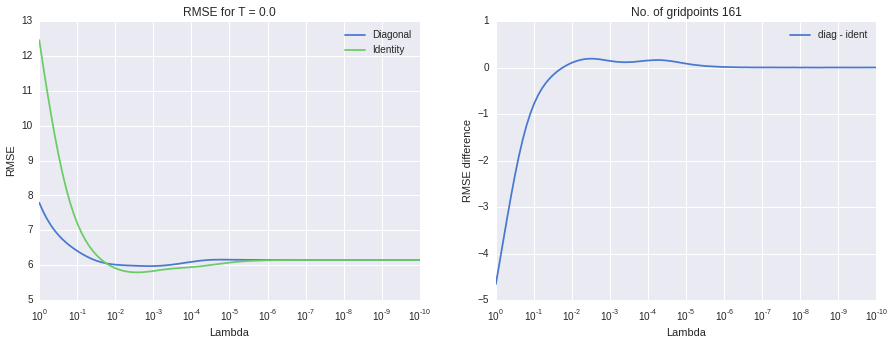

In [11]:
lambda_grid = np.logspace(0, -10, num=100)
gridSearch = autoGridSearchWithT(X,y, None, lambda_grid)

In [13]:
gridSearch.best_estimator_.getGridSize()

161L

gridSearch.best_estimator_ = SGRegressionLearner(T=0.0, lambdaReg=0.0029836472402833404, typeReg=0)
with level 3, 161 grid points

In [22]:
bestEstimator = SGRegressionLearner(T=0.0, lambdaReg=0.0029836472402833404, typeReg=0)
bestEstimator.fit(X,y)

In [56]:
mse = -bestEstimator.score(X,y)
ss_reg = mse * df.shape[0]

In [58]:
var = np.var(y)
ss_tot = var*df.shape[0]

In [61]:
r_2 = 1 - ss_reg/ss_tot
r_2

0.920136144089523

# Result vs orig. paper
https://www.researchgate.net/publication/222447231_Modeling_of_Strength_of_High-Performance_Concrete_Using_Artificial_Neural_Networks_Cement_and_Concrete_research_2812_1797-1808

best r^2 for training: 0.945 (ANN) and 0.782 (lin.reg)